# Hydrologische informatieproducten HDSR

Dit notebook bevat een workflow om geautomatiseerd een aantal hydrologische informatieproducten af te leiden uit modeluitvoer. 

## Inhoudsopgave
* [1. Voorbereiding](#voorbereiding)
* [2. Brondata](#brondata)
   * [2.1 Meteorologische forcering](#forcering)
       * [2.1.1 KLimaatscenario's](#scenarios)
       * [2.1.2 Historische gegevens](#historie)
   * [2.2 Hydromedah](#hydromedah)
   * [2.3 Mozart](#mozart)
* [3. Informatieproducten](#producten)
    * [3.1 Watervraag- en aanbod](#vraagaanbod)
    * [3.2 Maatgevende af- en aanvoer](#maatgevendeafaanvoer)    
    * [3.3 GxG's](#gxg)        
    * [3.4 Kwel/wegzijging](#kwelwegzijging)
    * [3.5 Rivierkwel](#rivierkwel)    
    * [3.6 Runoff karakteristieken](#runoff)
        * [3.6.1 AHN analyses](#runoff_ahn)
        * [3.6.2 Hydromedah analyses](#runoff_hydromedah)

<a id="voorbereiding"/>

# 1. Voorbereiding 

We hebben een aantal paden nodig die hier kunnen worden aangepast:

In [15]:
# De locatie waar hdsrshipy vanuit github is gedownload. Standaard is dit een niveau hoger dan dit notebook.
import os
package_path = os.path.abspath('../')

# De locatie waar de template-schematisatie van Hydromedah staat en waar ook de uitvoer wordt gegenereerd. 
# Ook historische mete-bestanden (uit WIWB) worden hier ook geplaastst. Let op: hier is relatief veel schijfruimte (~40 GB) voor nodig!
hydromedah_path = r'D:\4569.20\hdsrhipy_compleet\data\Hydromedah'#os.path.abspath('../data/hydromedah')

# KNMI klimaatscenario's worden niet noodzakelijkerwijs op dezelfde locatie geplaatst. Dit is het pad waar ze worden gedownload.
scenario_path = os.path.abspath('../data/scenarios')

# pad met validatiedata
data_path = os.path.abspath('../data/')

# De locatie waar de informatieproducten worden geplaastst.
export_path = os.path.abspath(r'D:\4569.20\hdsrhipy_compleet\results')

Laad een aantal externe benodigde bibliotheken en de klassen van het hdsrhipy-pakket.

In [26]:
import sys
import shutil
import ipywidgets
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx
matplotlib.rcParams['figure.figsize'] = [15, 10]
get_ipython().run_line_magic('matplotlib', 'inline')
sys.path.append(package_path)  
from hdsrhipy import Meteorology
from hdsrhipy import Hydromedah
from hdsrhipy import Groundwater
from hdsrhipy import Maatgevend
from hdsrhipy import WatervraagAanbod
from hdsrhipy import Runoff
from hdsrhipy import FlowStats
from hdsrhipy.core.nauwkeurigheid import *


<a id='brondata'/>


# 2. Brondata 

<a id='forcering'/>

## 2.1 Meteorologische forcering 

<a id='scenarios'/>

### 2.1.1. Klimaatscenario's

Rasters voor de gewenste klimaatscenario's zijn te downloaden via het KNMI Data Platform (KDP; https://dataplatform.knmi.nl/). Voor kleine hoeveelheden data is een 'open-data key' beschikaar, maar voor het downloaden van een complete dataset (zoals 30 jaar aan dagelijkse data) is een dedicated 'key' nodig die is te krijgen via [dataservices@knmi.nl](mailto:dataservices@knmi.nl). Als in onderstaand commando geen key wordt meegeven ('key=None') wordt de open-data-key gebruikt.

Voor nu zijn de scenario's voor zichtjaar 2085 gedownload. De database die beschikbaar is via de KNMI API-bevat een fout; de referentieverdamping voor het scenarios GL klopt namelijk niet (bleek uit communicatie met KNMI). Voor nu zijn dus de overige drie scenario's gedownload. Als de fout is opgelost kan op onderstaande wijze (en een aparte key) het resterende scenario worden klaargezet.

We bevelen aan in onderstaande alleen de paden aan te passen en, afhankelijk van de dataset, dataset_name en dataset_version. Voor de juiste combinaties: zie bovenstaande website.

In [4]:
meteo = Meteorology()
# zet aan d.m.v. True
if False:    
    # er zit volgens KNMI nog een fout in het GL scenario, dus download deze zes scenario's
    datasets = ['RD85WL', 'EV85WL','RD85WH','EV85WH','RD85GH','EV85GH']
    for dat in datasets:
        if dat.startswith('RD'):
            var = 'precipitation'
        elif dat.startswith('EV'):
            var = 'evaporation'
        
        # het moet in stukjes, want de API ondersteunt max. 1000 files per keer. Dus we doen 1 jaar per bevraging.
        for y in range(2070,2100):        
            print('Downloading '+dat+'for '+str(y)+'...')
            start = 'INTER_OPER_R___'+dat+'__L3__'+str(y)+'0101T080000_'+str(y)+'0102T080000_0014.nc'
            meteo.download_from_KNMI(api_key=None, variable=var, dataset_name=dat, dataset_version='014', max_keys=366, start_after=start, download_path = Path(scenario_path,dat))

<a id='historie'/>


### 2.2.2 Historische data

Historische gegevens van neerslag(radar) en referentiegewasverdamping (Makkink) halen we uit WIWB. Hier is voor de gewenste periode geen doorlopend product beschikbaar, dus we downloaden Meteobase neerslag voor jaren t/m 2018 en IRC Final reanalysis daarna. Makkink is voor de gehele periode beschikbaar. Het IRC-grid vereist enkele extra bewerkingen, hier wordt het geresampled naar het oorspronkelijke Meteobase raster voor consistentie.

Onderstaande functies ondersteunen voor nu alleen de variabelen 'precpitation' en 'evaporation' (referentiegewasverdamping). Start- en eindtijd dienen ingevuld te worden zoals onderstaand en de tijdstap is een combinatie van een cijfer en een letter: '1D' staat voor 1 dag, '6H' voor 6 uur. Hier is alleen 1D van toepassing. Niet alle combinaties zijn geldig en getest.

In [5]:
# WIWB credentials:
#credentials = (<HDSR_USERNAME>, <HDSR_PASSWORD>)

if False:
    # Meteobase neerslag t/m 2018
    meteo.download_from_WIWB(credentials=credentials, datasource='Meteobase.Precipitation', variable='precipitation', start='20100101000000', end='20190101000000', timestep='1D', download_path = Path(hydromedah_path))
    # Makkink verdamping
    meteo.download_from_WIWB(credentials=credentials, datasource='Meteobase.Evaporation.Makkink', variable='evaporation', start='20100101000000', end='20210101000000', timestep='1D', download_path = Path(hydromedah_path))
    # IRC vanaf 2019
    meteo.download_from_WIWB(credentials=credentials, datasource='Knmi.International.Radar.Composite.Final.Reanalysis', variable='precipitation', start='20190101000000', end='20210101000000', timestep='1D', download_path = Path(hydromedah_path))

<a id='hydromedah'/>

Het is ook mogelijk forcering klaar te zetten vanuit lokale NetCDF-betanden, via onderstaande functie. Hier is nc_path het pad waar de lokale bestanden staan en hydromedah_path (mag ook iets anders zijn), het pad waar de uitvoerbestanden worden geplaatst. dsvar is de naam in het netcdf-bestand. Als daarin geen schaalfactor van toepassing is, kan scaling_factor op 1 gezet worden (in dit geval is de eenheid 0.01 mm/d). het 3e argument wordt gebruikt voor de naamgeving van de uitvoer ascii-bestanden, die Hydromedah vervolgens inleest.

In [6]:
if False:
    # dit is een voorbeeld
    nc_path = Path(r'D:\4569.10\nonapi_forcering')
    meteo.from_netcdf(nc_path, hydromedah_path, 'evaporation', 'Days', dsvar='Evaporation', scaling_factor= 0.01)

<a id='hydromedah'>

# 2.2 Hydromedah 

Als de juiste forceringsdata is gedownload, kan Hydromedah gedraaid worden met de gedownloade data. Eerst dient een naam voor de berekening te worden gekozen. Vervolgens wordt een kopie gemaakt in '<hydromedah_path>/work/<name>' waar dan uitvoer verschijnt in een map met die naam. Voor het doen van een run zijn, afhankelijke van de periode, tot tientallen GB's aan schijfruimte nodig.

In [11]:
name="Huidig250"


# voor deze variabelen wordt Metaswap uitvoer weggeschreven
msw_vars = ['ETact','S01','Ssd01', 'qinf']

# maak een Hydromedah object aan. Precip_path en evap_path gaan uit van de 'root' van het pad en gaat ervanuit dat 'forcing/precipiation' of 'forcing/evaporation' worden toegevoegd.
# dus voor historische data:
hydromedah = Hydromedah(hydromedah_path=hydromedah_path, name=name, precip_path=hydromedah_path, evap_path=hydromedah_path)
if False:    
    # klimaatscenario's:
    # hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=os.path.join(scenario_path,'RD85WH'), evap_path=os.path.join(scenario_path,'EV85WH'))
    # hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=os.path.join(scenario_path,'RD85WL'), evap_path=os.path.join(scenario_path,'EV85WL'))
    # hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=os.path.join(scenario_path,'RD85GH'), evap_path=os.path.join(scenario_path,'EV85GH'))
    
    # zet het model klaar met deze eigenschappen. Het ruimtelijke domein is hard gecodeerd naar het HDSR-gebied. 
    hydromedah.setup_model(    start_date='2010-01-01', 
                               end_date='2021-07-31', 
                               resolution=250., 
                               add_surface_water=True, 
                               afw_shape = 'Afwateringseenheden', 
                               metaswap_vars = msw_vars,
                               use_existing_simgro=Path(hydromedah_path) / 'use_simgro',
                               firstrun=True) # dit alleen True als het de eerste run is, hiermee wordt de database uitgepakt.
    
    hydromedah.run_model(model_path=hydromedah_path, silent=True)

    # haal de lateralen op uit het model...
    laterals = hydromedah.read_laterals(model_path=hydromedah_path, model_name=name, msw_file='sw_dtgw')

    # en schrijf ze naar een csv.
    laterals.to_csv(os.path.join(export_path,'Maatgevend','laterals_'+name+'.csv'),sep=",")
    
    # Modeluitvoer is groot en we hebben lang niet alles nodig.  
    # Specifeer de variabelen en lagen die BEWAARD moeten blijven. Uit metaswap worden enkele grote CSV's en resterende binaire bestanden verwijderd.
    hydromedah.cleanup(model_path=hydromedah_path, name=name, 
                       modflow_vars = ['head','bdgflf'], 
                       modflow_layers = [1], 
                       metaswap_files = ['sw_dtgw'])                 

## Converteer lateralen uit HYDROMEDAH naar een LATERAL.DAT voor SOBEK

In [19]:
# laterals to lateral.dat
template_path = r'D:\4569.20\hdsrhipy_compleet\templates'
sobek_path = os.path.join(export_path, 'LATERAL.DAT')
csv_path  = os.path.join(export_path,'laterals_'+name+'.csv')
reaches_to_adjust = {'H013921_1':['PG0599-1','PG0034-1','PG2177-1'],
                                'kw_H000315_2_1':['PG2160-3','PG2160-5','PG2151-3'],
                                'H044390_1':['PG0756-1','PG0778-1'],
                                'kw_H065397_s1':['PG0557-1'],
                                'H006663_1_s3': ['PG2064-2', 'PG006-2']                    
                            }   
hydromedah.laterals2sobek(csv_path=csv_path, template_path=template_path, sobek_path=sobek_path,reaches_to_adjust=reaches_to_adjust)


Reading input...
Kromme rijn debiet of 4.0 applied to PG0026-3
Extra droogval toepassen voor lat_id PG0034-1 (gekoppeld aan reach H013921_1 distance = 1002.84 m
Extra droogval toepassen voor lat_id PG0557-1 (gekoppeld aan reach kw_H065397_s1 distance = 124.72 m
Extra droogval toepassen voor lat_id PG0599-1 (gekoppeld aan reach H013921_1 distance = 343.20 m
Extra droogval toepassen voor lat_id PG0756-1 (gekoppeld aan reach H044390_1 distance = 146.38 m
Extra droogval toepassen voor lat_id PG0778-1 (gekoppeld aan reach H044390_1 distance = 204.32 m
Extra droogval toepassen voor lat_id PG2064-2 (gekoppeld aan reach H006663_1_s3 distance = 442.75 m
Try to adjust PG2151-3, but it is not in Hydromedah output.
Extra droogval toepassen voor PG2151-3 based on rational method
Extra droogval toepassen voor lat_id PG2160-3 (gekoppeld aan reach kw_H000315_2_1 distance = 381.59 m
Extra droogval toepassen voor lat_id PG2160-5 (gekoppeld aan reach kw_H000315_2_1 distance = 367.71 m
Extra droogval toep

## Bereken debietstatstieken op basis van Sobek resultaten

De Sobek berekeningen zelf vergen veel tijd en zijn niet haalbaar om binnen deze omgeving te draaien.

In dit geval zijn de berekeningen gesplitst in periodes van 13 maanden (steeds 1 maand inlooptijd), welke parallel zijn doorgerekend. We hebben dus nu 12 cases met daarin 12 Sobek uitvoerbestanden, die we gaan combineren om de statistieken uit te lezen.

Het model is doorgerekend in 12 delen, met elk een case. We gebruiken ze allemaal:

In [31]:
cases = range(1,13)
hisfiles = r'D:\4569.20\testout_sobek\MOD_ADJ_V4.lit'

Dit zijn de settings voor de debietstatistiek:

In [32]:
# maanden in het jaar om statistiek over te berekenen. De maand- en dag van deze periode wordt gebruikt om te bepalen of de dag moet worden meegenomen
period = pd.date_range(start=pd.Timestamp('1900-05-15'),end=pd.Timestamp('1900-09-15'), freq='D')

# de 'name' wordt gebruikt als kolom in de shapefile, de waarde is het debiet (m3/s) om te bepalen hoe vaak het wordt overschreden. Het resultaat is het aantal dagen.
overschrijdingsduur_van_debiet = {'name': 'Ex5-9_005',  'value': 0.05}
# Idem, maar nu is het resultaat de fractie van de tijd dat de waarde wordt overschreden
relatieve_overschrijdingsduur_van_debiet = {'name': 'REx5-9_005',  'value': 0.05}
# en dit geeft het debiet dat x % van de tijd wordt overschreden
debiet_bij_tijdpercentiel = {'name': 'Q5-9_80%',  'value': 0.8}

Het resultaat is een shapefile 'flowstats.shp' met alle watergangen. De statistieken zijn als kolommen opgenomen in de shapefile. Naast bovenstaande zijn dat gemiddelde en variantie.

In [33]:
flowstats = FlowStats(sobek_path=hisfiles, template_path=template_path, export_path=os.path.join(export_path, 'flowstats.shp'))
flowstats.get_flowstats(cases2join=cases, period=period, overschrijdingsduur_van_debiet=overschrijdingsduur_van_debiet, relatieve_overschrijdingsduur_van_debiet=relatieve_overschrijdingsduur_van_debiet,debiet_bij_tijdpercentiel=debiet_bij_tijdpercentiel)


<a id='mozart'/>

## 2.3 Mozart

Het LHM is het geïntegreerd landsdekkend grond- en oppervlaktewatermodel van Nederland. In dit script richten we ons op de uitvoer van het deelmodel Mozart, dat de watervraag, het wateraanbod en het watertekort voor het regionale oppervlaktewatersysteem in beeld brengt. Mozart simuleert voor kleine stroomgebieden de waterbalans van het oppervlaktewatersysteem, zie Figuur 1. Deze stroomgebieden (ook bekend als LSW’s, Local Surface Waters). We gebruiken de modeluitvoer die gebruikt is voor de validatie van het LHM 4.1. Deze gegevens zijn inzichtelijk via: https://nhi.nu/nl/index.php/modellen/lhm/nhi-lhm/v41/.

De toekomstige ontwikkeling van de watervraag en het wateraanbod wordt bepaald met klimaatscenario’s. De KNMI’14-scenario’s zijn afgeleid van de mondiale scenario’s van het IPCC en worden in Nederland door alle waterbeheerders gebruikt in besluitvorming over klimaat-gerelateerde opgaves. Via de Helpdesk Water zijn de basisprognoses 2018 beschikbaar. Deze prognoses bevatten o.a. Mozart-modelruns voor de KNMI’14-scenario’s. Op basis van deze modeluitvoer wordt een factor bepaald tussen de referentiemodelrun en een klimaatscenario-run. Deze factor wordt vervolgens gebruikt om de toekomstige ontwikkeling van de watervraag en het wateraanbod te bepalen.

<a id='producten'/>

# 3 Producten

<a id='vraagaanbod'/>

## 3.1 Watervraag- en aanbod

Deze sectie schaalt Mozart-uitvoer van LSW-schaal naar peilgebieden-schaal.
Daarnaast wordt de onzekerheid van de schaling in kaart gebracht door het toekennen van een onzekerheidsfactor op de top10nl-oppervlakten.
Ook wordt door middel van de basisprognoses een factor toegekend om zo de verandering van de watervraag, -aanbod en -tekort in de toekomst in beeld te brengen.

De volgende gegevens worden gebruikt in deze analyse:
* Topografische basisbestand : top10nl
* Uitvoer Mozart: Validatie LHM 4.1 (periode 2011-2020)
* Peilgebieden: data Hoogheemraadschap De Stichtse Rijnlanden
* Toekomstscenarios: Basisprognoses DPZW

Allereerst worden alle bestandsnamen gedefinieerd:

In [3]:
# definitie van een dictionary voor de bestandsnamen
fNames = dict()

# top10nl
#fNames['top10nl'] = os.path.join(data_path, 'gis', 'top10nl_terrein_water_weg.gpkg')
fNames['top10nl'] = r'd:\projecten\hydrologische_informatieproducten\werkmap\data\top10nl\clip\top10nl_terrein_water_weg.gpkg'

# koppelcodes top10nl en Mozart
#fNames['top10nl_koppeling'] = os.path.join(data_path,'mozart','koppeling_top10nl_mozart.xlsx')
fNames['top10nl_koppeling'] = r'd:\projecten\hydrologische_informatieproducten\werkmap\data\top10nl\koppeling_top10nl_mozart.xlsx'

# LSW-polygonen
#fNames['lsw'] = os.path.join(data_path, 'gis', 'lsw_hdsr_large.shp')
fNames['lsw'] = r'd:\projecten\hydrologische_informatieproducten\werkmap\data\geo\lsw\lsw_hdsr_large.shp'

# afwateringseenheden
#fNames['afwateringseenheden'] = os.path.join(data_path, 'gis','afwateringseenheden.shp')
fNames['afwateringseenheden'] = r'd:\projecten\hydrologische_informatieproducten\werkmap\data\GISdata\afwateringseenheden.shp'

# uitvoer mozart
#fNames['mozart_out'] =  os.path.join(data_path, 'mozart','lswwaterbalans.out')
fNames['mozart_out'] =  r'd:\projecten\hydrologische_informatieproducten\werkmap\data\mozart\lswwaterbalans.out'

# definieren van resultaatmappen
ref_dir = os.path.join(export_path,'watervraagaanbod','referentie')
min5_dir = os.path.join(export_path,'watervraagaanbod','min5')
plus5_dir = os.path.join(export_path,'watervraagaanbod','plus5')
if not os.path.exists(ref_dir):
    os.makedirs(ref_dir)
    os.makedirs(min5_dir)
    os.makedirs(plus5_dir)

Vervolgens worden alle data ingelezen door het initieren van de WatervraagAanbod-klassen. 
Er worden drie instanties gemaakt: een referentie-analyse en twee analyses voor het bepalen van de onzekerheid van de analyse.

Ook wordt het schaalniveau bepaald. In het voorbeeld schalen we de LSW-gegevens naar afwateringseenhedenniveau.

In [4]:
referentie = WatervraagAanbod(fNames)
ref_min5 = WatervraagAanbod(fNames)
ref_plus5 = WatervraagAanbod(fNames)

# bepaal interessegebieden
referentie.invoerdata['schaalgebied'] = referentie.invoerdata['afwateringseenheden']
ref_min5.invoerdata['schaalgebied'] = ref_min5.invoerdata['afwateringseenheden']
ref_plus5.invoerdata['schaalgebied'] = ref_plus5.invoerdata['afwateringseenheden']


Data correct ingeladen.
Data correct ingeladen.
Data correct ingeladen.


Vervolgens wordt de schaling voor elke LSW uitgevoerd en de resultaten weggeschreven naar csv-bestanden:

In [5]:
# verkrijg de LSW-nummers
lswNrs = referentie.invoerdata['lsws']['LSWFINAL']

print("Uitvoeren schaling lsw's naar schaalgebieden")
for _, lsw_nr in tqdm(lswNrs[:].iteritems()):

    # voer referentieanalyse uit
    referentie.uitvoeren_schaling(lsw_nr, onzekerheid_opp=0)

    # definieer onzekerheid oppervlaktes top10nl
    ref_min5.uitvoeren_schaling(lsw_nr, onzekerheid_opp=-0.05)
    ref_plus5.uitvoeren_schaling(lsw_nr, onzekerheid_opp=0.05)

referentie.schaling_naar_csv(ref_dir)
ref_min5.schaling_naar_csv(min5_dir) 
ref_plus5.schaling_naar_csv(plus5_dir)


Uitvoeren schaling lsw's naar schaalgebieden


0it [00:00, ?it/s]

Daarna kunnen de resultaten in een overzichtskaart gevisualiseerd worden. De gebruiker kan hierbij de interesseperiode bepalen. Ook kan de gebruikersfunctie gekozen worden (landbouw of peilbeheer (water)). Ook dient gedefinieerd te worden of de watervraag, het wateraanbod of het watertekort gevisualiseerd dient te worden:

In [ ]:
periode_start = '2018-06-01'
periode_end = '2018-08-01'
gebruiker = 'landbouw'
aspect = 'watertekort'

# definieer kolom voor data watervraag in geodataframe
referentie.invoerdata['schaalgebied'][f'{aspect}{gebruiker}'] = np.nan

for index, row in referentie.invoerdata['schaalgebied'].iterrows():
    key = row['CODE']

    try:
        df = pd.read_csv(fr'{ref_dir}\mozart_schaalgebied_{key}_geschaald.csv',
                        parse_dates=True,
                        index_col=['TIMESTART'])

        df_tekort = df.loc[periode_start:periode_end, f'watertekort_{gebruiker}']

        totaal_tekort = df_tekort.sum()

        referentie.invoerdata['schaalgebied'].loc[index, f'{aspect}{gebruiker}'] = totaal_tekort.item()

    except FileNotFoundError:
        print(f"{row['CODE']} not found")

# zet watervraag om: van m^3 naar Mm^3
referentie.invoerdata['schaalgebied'][f'{aspect}{gebruiker}_Mm3'] = referentie.invoerdata['schaalgebied'][f'{aspect}{gebruiker}']/1_000_000


fig, ax = plt.subplots(figsize=(20, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2) 
cbar = referentie.invoerdata['schaalgebied'].to_crs(epsg=3857).plot(ax=ax, column=f'{aspect}{gebruiker}_Mm3', legend=True)
cx.add_basemap(ax)
ax.set_title(f'Watertekort {gebruiker} in periode {periode_start} - {periode_end}')
cax.set_ylabel('Watertekort [$Mm^3$]')
ax.set_xlabel('X-coordinaat')
ax.set_ylabel('Y-coordinaat')


De onzekerheid in b.v. de geschaalde watervraag op basis van onnauwkeurigheden in top10nl kan gevisualiseerd worden als een bandbreedte. Hieronder is een voorbeeld te zien voor afwateringsgebied PG0714-42:

In [ ]:
#%% visualisatie van onzekerheid oppervlakte top10nl (b.v. watervraag landbouw)
code_afwateringsgebied = 'PG0714-42'

df_ref = pd.read_csv(f'{ref_dir}\mozart_schaalgebied_{code_afwateringsgebied}_geschaald.csv', parse_dates=True, index_col=[0])
df_min5 = pd.read_csv(f'{min5_dir}\mozart_schaalgebied_{code_afwateringsgebied}_geschaald.csv', parse_dates=True, index_col=[0])
df_plus5 = pd.read_csv(f'{plus5_dir}\mozart_schaalgebied_{code_afwateringsgebied}_geschaald.csv', parse_dates=True, index_col=[0])

fig, ax = plt.subplots()
df_ref['watervraag_landbouw'].plot(ax=ax, legend=False)
ax.fill_between(df_min5.index, df_min5['watervraag_landbouw'], df_plus5['watervraag_landbouw'], color='grey')


Tot slot kunnen de klimaatscenario's gebruikt worden om de toekomstige watervraag en behorend tekort in te schatten. Hiervoor wordt een factor berekend waarmee de referentie-modelresultaten geschaald worden. Ook kan er een onzekerheidsfactor op de klimaatfactor verdisconteerd worden om een onzekerheidsschatting van de toekomstschatting te maken. Vervolgens kunnen de toekomstige watervraag en bijbehorende onzekerheidsschatting gevisualiseerd worden in een figuur.

In [ ]:
# definieer de scenarios
scenarios = ['REF2017', 'W2050']

# definieer de map waar de scenario-data staan
directory = os.path.join(data_path,'mozart')

# bepaal factor d.m.v. klimaatscenarios
referentie.bepaal_factor_klimaatscenarios(directory, scenarios)

# definieer onzekerheid klimaatfactor
onzekerheid_klimaat = 0.05 # 5%

df_ref_watervraag_toekomst = df_ref*referentie.klimaatfactor['watervraag']
df_min5_watervraag_toekomst = df_ref*(referentie.klimaatfactor['watervraag']-onzekerheid_klimaat)
df_plus5_watervraag_toekomst = df_ref*(referentie.klimaatfactor['watervraag']+onzekerheid_klimaat)


In [ ]:
#%% visualisatie van onzekerheid klimaatscenarios
fig, ax = plt.subplots()

df_ref['watervraag_landbouw'].plot(ax=ax, legend=False)
df_ref_watervraag_toekomst['watervraag_landbouw'].plot(ax=ax, legend=False)
ax.fill_between(df_min5.index, df_min5_watervraag_toekomst['watervraag_landbouw'], df_plus5_watervraag_toekomst['watervraag_landbouw'],
                color='grey')

<a id='maatgevendeafaanvoer'/>

## 3.2 Maatgevende af- en aanvoer

Op basis van de laterale af- en aanvoer uit Hydromedah worden de maatgevende af- en aanvoer bepaald. De maatgevende afvoer is de dagelijks gemiddelde afvoer die 1 a 2 dagen per jaar wordt overschreden, de maatgevende aanvoer is de 10-daags gemiddelde aavvoer die ongeveer eens in de 10 jaar wordt overschreden.

Hydromedah geeft de laterale afvoer per afwateringseeneheid en dat is ook de ruimtelijke eenheid waarop de resultaten worden gepresenteerd. Aanvullend is inzicht gewenst in de bijdrage van kwel/wegzijging aan de maatgevende af- en aanvoer. We bepalen dus ook de laterale af- en aanvoer waarbij we per afwateringseenheid de kwel/wegzijging van de flux af trekken. Hierbij kan de kwel/wegzijging eerst zijn gemiddeld in de tijd (dat gaat snel), of niet (langzaam). De extra rekentijd wordt veroorzaakt door het bepalen van de gemiddelde flux per afwateringseenheid; in het eeste geval hoeft dat maar één keer.

Kies hier het de periode waarvoor de maatgevende afvoer bepaald dient te worden. De volledige code inclusief de bepaling van de bandbreedte werkt alleen voor de historische periode.

In [ ]:
name = "Huidig250"
# name = "WH85250"
# name = "WL85250"
# name = "GH85250"

We bepalen eerst de lateralen zonder kwel/wegzijging.

In [ ]:
mg = Maatgevend(name=name, export_path=export_path) 
mg.get_laterals(seepage_subtracted=False)
qnorm = mg.get_q_norm(dataset = mg.laterals)

Bereken nu de lateralen zonder kwel/wegzijging. Deze worden ook in CSV-formaat in de export_folder geplaatst. Kies met 'mean_seepage' voor al dan niet gemiddelde kwel/wegzijging.

In [ ]:
mg.subtract_seepage(mean_seepage = True , model_path = hydromedah_path, name=name)
mg.get_laterals(seepage_subtracted=True, mean_seepage=True)
qnorm_nosp = mg.get_q_norm(dataset = mg.laterals_nosp)

We exporteren de resultaten met en zonder kwel naar shape-bestanden. Deze bevatten zowel maatgevende aan- als afvoer in zowel m3/s als l/s/ha.

In [ ]:
qnorm.head()

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15,10]
fig, ax = plt.subplots(1,2)
qnorm.plot('MQAF_LSHA',ax=ax[0],cmap='jet', vmin=0,vmax=1.5, legend=True, legend_kwds={'label': "Qaf [l/s/ha]",'orientation': "horizontal"})

qnorm_nosp.plot('MQAF_LSHA',ax=ax[1],cmap='jet', vmin=0,vmax=1.5,legend=True , legend_kwds={'label': "Qaf (geen kwel) [l/s/ha]",'orientation': "horizontal"})
fig, ax = plt.subplots(1,2)
qnorm.plot('MQAAN_LSHA',ax=ax[0],cmap='jet',vmin=0,vmax=1, legend=True , legend_kwds={'label': "Qaan [l/s/ha]",'orientation': "horizontal"})
qnorm_nosp.plot('MQAAN_LSHA',ax=ax[1],cmap='jet',vmin=0,vmax=1, legend=True , legend_kwds={'label': "Qaan (geen kwel) [l/s/ha]",'orientation': "horizontal"})


Ook is er een functie ingebouwd om resultaten voor een bepaalde locatie nader te bekijken. Deze heeft als invoer het volgnummer van de afwateringseenheid in de shape (dit is wat Hydromedah als codering gebruikt). Hierbij kan alleen de ruwe data (seepage_subtracted=False), of de data zonder kwel/wegzijging (seepage_subtraced=True) geplot worden. De plaatjes worden als PNG weggeschreven naar de export map.

In [ ]:
%matplotlib inline
mg.plot_location(113, seepage_subtracted=True)

Op onderstaande manier kan een figuur worden verkregen voor alle locaties. Er zijn enkele kleine of langgerekte gebieden waaraan geen Hydromedah cel kan worden gealloceerd en waarvoor geen data beschikbaar is: deze worden overgeslagen.

In [ ]:
plotting = range(1,1800,300)
for i in plotting:
     try:
         mg.plot_location(i, seepage_subtracted=True)
     except:
         print('Figure failed.')

De bandbreedte voor de Monte Carlo-analyse leiden we af uit tijdreeksen van af- en aanvoeren uit het WIS. Gevalideerde metingen zijn geaggregeerd naar afvoergebieden. De data van niet elk afvoergebied kan rechtstreeks gebruikt worden, aangezien sommige afvoergebieden op elkaar afwateren. 

Eerst bewerken we de de geaggregeerde metingen en maken er dataframe van af- en aanvoer van.

In [ ]:
# read and preprocess the validation data
validation_series = os.path.join(data_path,'surfacewater','debieten_afvoergebieden.csv')
data = pd.read_csv(validation_series)
data[data=='-999'] = np.nan
data.drop([col for col in data.columns if 'quality' in col], axis=1, inplace=True)
afvoer = data.iloc[:,[i for i in range(len(data.columns)) if data.iloc[0,i] == 'H.B.u.d']]
aanvoer = data.iloc[:, [i for i in range(len(data.columns)) if data.iloc[0,i] == 'H.B.i.d']]
afvoer.drop([0], axis=0, inplace=True)
aanvoer.drop([0], axis=0, inplace=True)
afvoer.index = [pd.Timestamp(data.iloc[i,0]) for i in range(len(data.iloc[1:,0]))]
afvoer.columns = [afv.rstrip('.1') if '.1' in afv else afv for afv in afvoer.columns]
aanvoer.index  = [pd.Timestamp(data.iloc[i,0]) for i in range(len(data.iloc[1:,0]))]

<a id='gxg'/>

We kiezen afvoergebied Zegveld, uiteraard is hier een ander gebied voor te nemen dat geen afvoer ontvangt van bovenstroomse gebieden.

In [ ]:
if name=='Huidig250':
    afgid = 'AFVG13' # Zegveld
    netto = mg.get_validation(afgid=afgid, afvoer=afvoer, aanvoer=aanvoer)

we plotten de twee reeksen en het onderlinge verschil, en bepalen de bandbreedte als die afwijking waar één standaardafwijking (67%) van de datapunten in valt.

In [ ]:
if name=='Huidig250':
    fig, axs = plt.subplots(2)
    axs[0].plot(netto.WIS,color='blue', label='WIS')
    axs[0].plot(netto.HYDROMEDAH,color='red', label='Hydromedah')
    axs[0].legend()
    axs[0].set_ylabel('Verschil [mm/d]')
    axs[1].plot(netto.HYDROMEDAH-netto.WIS,color='black', label='Verschil')
    mg_bandwidth = [np.percentile(netto.ERROR, 17), np.percentile(netto.ERROR, 83)]

Deze bandbreedte combineren we met een bootstrap. We voegen de uitersten toe aan een shapefile en schrijven die weg. Dit is het eindresultaat.

In [ ]:
if name=='Huidig250':
    mg_samples = sample_nauwkeurigheid(mg.laterals, mg_bandwidth, n=2)
    (mins, maxs)  = MonteCarlo('normative', mg_samples, bootstrap_n=2, n=2)

In [ ]:
if name=='Huidig250':
    qnorm['QAF_LSHA_MIN'] = mins[0]
    qnorm['QAAN_LSHA_MIN'] = mins[1]
    qnorm['QAF_LSHA_MAX'] = maxs[0]
    qnorm['QAAN_LSHA_MAX'] = maxs[1]

In [ ]:
mg.export_shp(qnorm, 'Qm_'+name+'.shp')
mg.export_shp(qnorm_nosp, 'Qm_'+name+'_geen_kwel.shp')

# 3.3 GxG's en grondwatertrap

Op basis van de Modflow uitvoer bepalen stellen we de volgende kaarten samen:
 - GHG (gemiddelde van de drie hoogste grondwaterstanden in een hydrologisch jaar, gemiddeld over tenminste 8 jaar);
 - GLG (gemiddelde van de drie laagste grondwaterstanden in een hydrologisch jaar, gemiddeld over tenminste 8 jaar);
 - GVG (gemiddelde grondwaterstand over 14 maart, 28  maart en 14 april, gemiddeld over tenminste 8 jaar);
 - GT (grondwatertrap, gebaseerd op de drie GxG-kaarten).
 
 We stellen eerst deze producten samen op basis van de complete meetreeks, en voegen hierna de nauwkeurigheid daaraan toe.

We maken eerst een 'groundwater' - object aan en geven de paden en naam van de Hydromedah-berekening mee. Resultaten worden naar 'export_path' geschreven.

In [ ]:
# initialiseer het object. De hierboven gedefinieerde locaties voor modeluitvoer e.d. worden meegegeven.
gw = Groundwater(model_path=hydromedah_path, export_path=export_path, name='Huidig250')

Haal de stijdghoogtes op uit Hydromedah.

In [ ]:
gw.get_heads_raster()

Bereken de GxG's. Deze worden omgerekend naar diepte onder maaiveld via een maaiveldraster. Standaard wordt het Hydromedah raster (25m) geaggregeerd naar de modelresolutie en gebruikt, maar een alternatief is op te geven.

In [ ]:
means = gw.get_gxg_raster(mv_raster=None)

Plot de resultaten:

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15,10]
ax1 = plt.subplot(221)
plt.imshow(means['ghg'], cmap='jet', vmin=0,vmax=200)
ax1.set_title('GHG [m-mv]')
ax2 = plt.subplot(222)
plt.imshow(means['glg'], cmap='jet', vmin=0,vmax=200)
ax2.set_title('GLG [m-mv]')
ax3 = plt.subplot(223)
plt.imshow(means['gvg'], cmap='jet', vmin=0,vmax=200)
ax3.set_title('GVG [m-mv]')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

Op basis van de GxG's wordt de grondwatertrappenkaart berekend. Onderstaande indeling van grondwatertrappen is aangehouden (uit: Knotters e.a. (2018), Landsdekkende, actuele informatie over grondwatertrappen digitaal
beschikbaar, H20.)

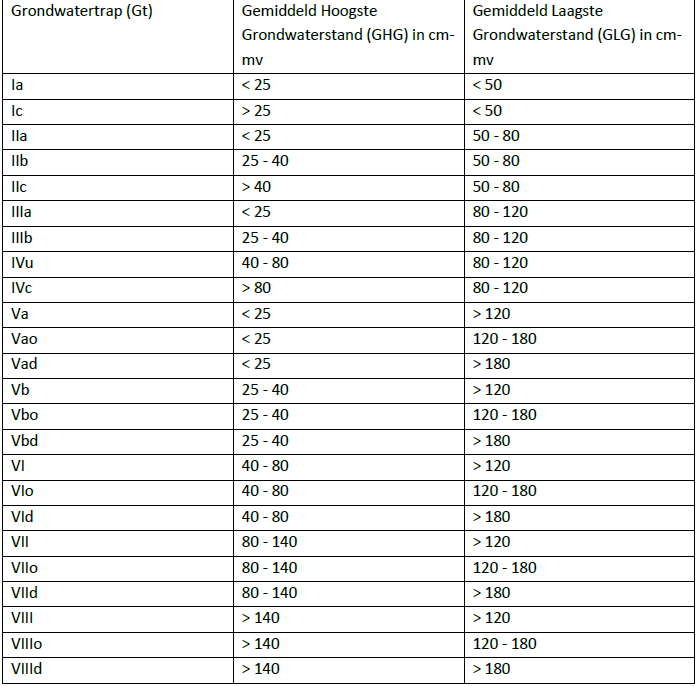

In [ ]:
means['gt'] = gw.get_gt_raster(gxg=means)

plt.imshow(means['gt'], cmap='jet', vmin=0, vmax=24)
plt.colorbar()
plt.show()

Vervolgens wordt, op basis van code uit de validatie van het LHM, een validatie van Hydromedah-grondwaterstanden uitgevoerd. Hiervoor is een gecombineerde dataset samengesteld van peilbuizen in het bovenste (freatische) watervoerende pakket, voor de periode 01/01/2010 - 31/7/2021 - dezelfde periode als bovenstaande Hydromedah run. 

'get_validation_data' roept de code aan die is overgenomen uit het project 'validatie_LHM' om statistieken te berekenen en een vergelijkingstabel met Hydromedah te maken.

In [ ]:
catalogue_file = 'alle_aanwezig.csv'
timeseries_file = 'alle_reeksen.csv'
head_path = os.path.join(hydromedah_path, 'work', 'Huidig250', 'output', 'head')     
gw.get_validation_data(validation_path=os.path.join(data_path,'grondwater'), catalogue=catalogue_file, timeseries=timeseries_file, head_path=head_path)

De scripts resulteren in een groot aantal bestanden waarvan de belangrijkste de verschilstatistieken per peilbuis tussen Hydromedah en de metingen bevat. Deze lezen we in en we kiezen alleen die buizen die de filtering in de validatiescripts heeft overgelaten.

In [ ]:
csvfile = os.path.join(data_path,'grondwater','results','with LHM','statistics_measured_modeled.csv')
summary = pd.read_csv(csvfile,sep=",")
summary.dropna(axis=0,inplace=True, subset=['GHG'])

Het is mogelijk om voor individuele afvoergebieden de een bandbreedte te bepalen, in dat geval worden die buizen geselecteerd die erin liggen. In dit geval kiezen we voor 'all' en worden peilbuieze in he gehele beheersgebied gebruikt om een bandbreedte te bepalen. We middelen de fout (het verschil) in GHG, GVG en GLG en gebruiken als bandbreedte het 17% en 83%-percentiel zodat een standaardafwijking (67%) van de data daarbinnen valt. Deze keuze is uiteraard relatief arbitrair en is aan te passen in onderstaande code.

De volledige tabel met kwaliteitsindicatoren is te vinden op bovenstaande locatie (csv-file).

In [ ]:
afg = 'all'
afgid  = os.path.join(data_path,'gis','afvoergebieden.shp')
gdf_afg = gpd.read_file(afgid)
if afg == 'all':
    geom = gdf_afg.unary_union
else:    
    geom = gdf_afg[gdf_afg['GAFNAAM'] ==afg].geometry

gdf = gpd.GeoDataFrame(summary, geometry=gpd.points_from_xy(summary.X_RD_CRD, summary.Y_RD_CRD))
subset = gdf[gdf.geometry.within(geom)]
means_gxg = [np.mean([i['GHG_ERROR'], i['GLG_ERROR'],i['GVG_ERROR']]) for _,i in subset.iterrows()]
head_bandwidth = [np.percentile(means_gxg,17), np.percentile(means_gxg, 83)]


We berekenen de nauwkeurigheid uit een Monte Carlo analyse. Deze bestaat uit een aantal componenten. Met de eeerste functie worden de basisdata 'n'x verstoord door er ruis uit een uniforme verdeling met de hierboven afgeleide bandbreedte bij op te tellen.

In [ ]:
head_samples = sample_nauwkeurigheid(gw.heads, head_bandwidth, n=5)  

Deze wordt gecombineerd met een bootstrap ('bootstrap_n' willekeurige periodes van 8 jaar). Deze levert een min/max versie van de GxG's. Voor elke realisatie wordt ook de GT bepaald. 

In [ ]:
(mins, maxs) = MonteCarlo('gxg', head_samples, bootstrap_n=5, n=10, model_path=hydromedah_path, model_name='Huidig250')

Zowel het 'best estimate' als de bandbreedte op basis van Monte Carlo wordt weggeschreven als tif-betanden.

In [ ]:
items = ['GHG','GLG','GVG','GT']
name='Huidig250'
for i in range(4):
    gw.export_raster(means[items[i].lower()], items[i]+'_best_'+name+'.tif')
    gw.export_raster(mins[i], items[i]+'_min_'+name+'.tif')
    gw.export_raster(maxs[i], items[i]+'_max_'+name+'.tif')    

<a id='kwelwegzijging'/>

## 3.4 Kwel/wegzijging

De kwel/wegzijgingsflux wordt door Modflow berekend als opwaarste flux naar de bovenste MOdflow laag toe. Deze halen we op, en vervolgens berekenen we de kwel/wegzijging per seizoen. We gaan uit van zes seizoenen, onderverdeeld in 4 (3-maandelijkse) of in 2 (6-maandelijkse) seizoenen:
Vier seizoenen:
    1 winter (DJF);
    2 Voorjaar (MAM);
    3 Zomer (JJA)
    4 Najaar (SON)
Twee seizoenen: 
    5 Winter6mnd (ONDJAM)
    6 Groeiseizoen (AMJJAS)
    
De naamgeving hiervan is vrij te kiezen, maar de volgorde van deze zes seizoenen staat vast. De zes seizoenen worden eerst uit de data afgeleid daarna wordt de bandbreedte afgeleid. Ook hier is de onzekerheid moeilijk te kwantificeren: we kiezen 0.1 mm/d als bandbreedte om de modelonzekerheid te kwantificeren en trekken daar n=3 keer uit. Vervolgens passen we bootstrap_n=3 keer bootstrap toe en samplen n=5 keer uit de gecombineerde dataset.

In [ ]:
# haal de data op (in mm/d)
seepage = gw.get_seepage()
# bepaal de seizoensgemiddelden
means = gw.seepage_season_means(seepage)

# en sample over de bandbreedte, gecombineerd met bootstrap.
sp_samples = sample_nauwkeurigheid(seepage, [-0.5,0.5], n=3)
(mins, maxs)  = MonteCarlo('seepage', sp_samples, bootstrap_n=3, n=5)

# exprteer de rasters naar tif-bestanden.
months = ['W','V','Z','N','GROEISEIZOEN','WINTER6']
for i in range(6):
    gw.export_raster(means[i], 'SP_best_'+months[i]+'_'+name+'.tif')
    gw.export_raster(mins[i], 'SP_min_'+months[i]+'_'+name+'.tif')
    gw.export_raster(maxs[i], 'SP_max_'+months[i]+'_'+name+'.tif')    

Maak een figuur aan met de gemiddelde waarden:

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15,10]
ax1 = plt.subplot(321)
plt.imshow(means[0], cmap='jet_r', vmin=-1,vmax=1)
ax1.set_title('Winter [mm/d]')
ax2 = plt.subplot(322)
plt.imshow(means[1], cmap='jet_r', vmin=-1,vmax=1)
ax2.set_title('Voorjaar [mm/d]')
ax3 = plt.subplot(323)
plt.imshow(means[2], cmap='jet_r', vmin=-1,vmax=1)
ax3.set_title('Zomer [mm/d]')
ax4 = plt.subplot(324)
plt.imshow(means[3], cmap='jet_r', vmin=-1,vmax=1)
ax4.set_title('Najaar [mm/d]')
ax4 = plt.subplot(325)
plt.imshow(means[4], cmap='jet_r', vmin=-1,vmax=1)
ax4.set_title('Groeiseizoen [mm/d]')
ax4 = plt.subplot(326)
plt.imshow(means[5], cmap='jet_r', vmin=-1,vmax=1)
ax4.set_title('Rest van het jaar [mm/d]')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

<a id='runoff'/>

<a id='rivierkwel'/>

## 3.4 Rivierkwel

Naast de totale gebiedsbrede flux, is ook inzicht gewenst in de invloed van hoge Lek-waterstanden. We passen daartoe de peilen op de Lek aan met onderstaande waterstanden. Zie het rapport voor meer achtergrond.

In [ ]:
offsets = [0.0]+[x-3.65 for x in [3.25, 5.14, 6.30]]
offsetnames = ['REF','T1','T10','T100']
for io, o in enumerate(offsets):
    gw.prep_riverseep(offset=o, offset_name=offsetnames[io], seizoen='WINTER', export_path=os.path.join(data_path,'peilen','winter'))
    gw.prep_riverseep(offset=o, offset_name=offsetnames[io], seizoen='ZOMER', export_path=os.path.join(data_path,'peilen','zomer'))

Nu wordt voor de vier herhalingstijden een Hydromedah run van één jaar gedraaid om het verschil in beeld te brengen.

In [ ]:
if False: # berekeningen duren lang, deze worden alleen uitgevoerd als dit statement "True" is.
    for i,offset in enumerate(offsetnames):

        # maak een Hydromedah object aan. Precip_path en evap_path gaan uit van de 'root' van het pad en gaat ervanuit dat 'forcing/precipiation' of 'forcing/evaporation' worden toegevoegd.
        hydromedah = Hydromedah(data_path=hydromedah_path, name='Rivierkwel_'+offset, precip_path=hydromedah_path, evap_path=hydromedah_path)
        # zet het model klaar. We hebben geen oppevlaktewater-model en Metaswap uitvoer nodig.
        hydromedah.setup_model(start_date='2010-01-01', end_date='2010-12-31', resolution=250., add_surface_water=False, afw_shape = '', metaswap_vars = [])
        # geef de zojuist geproduceerde peilen mee aan Hydromedah
        zomerpeil = os.path.join(data_path,'peilen','zomer','ZOMER_PEIL_LAAG1_1_'+offset+'.IDF')
        winterpeil = os.path.join(data_path,'peilen','winter','WINTER_PEIL_LAAG1_1_'+offset+'.IDF')
        # draai het model
        hydromedah.run_model(use_summerlevel=zomerpeil, use_winterlevel=winterpeil,silent=True )
        # en ruim overbodige uitvoer op
        hydromedah.cleanup(model_path=hydromedah_path, name='Rivierkwel_'+offset, 
                               modflow_vars = ['head','bdgflf'],
                               modflow_layers = [1],
                               metaswap_files = [])    

Haal nu voor dezelfde zes seizoenen de kwel/wegzijging data op voor het doorgerekende jaar.

In [ ]:
seeplist = []
for offset in offsetnames:
    gwt = Groundwater(model_path=hydromedah_path, export_path=export_path, name='Rivierkwel_'+offset)
    temp_seep  = gwt.get_seepage()
    seeplist.append(gwt.seepage_season_means(temp_seep))

In [ ]:
months = ['W','V','Z','N','GROEISEIZOEN','WINTER6']
name ='Huidig250'
for i in range(0,6):
    gw.export_raster(seeplist[1][i] - seeplist[0][i], 'SP_river_T1_'+months[i]+'_'+name+'.tif')
    gw.export_raster(seeplist[2][i] - seeplist[0][i], 'SP_river_T10_'+months[i]+'_'+name+'.tif')
    gw.export_raster(seeplist[3][i] - seeplist[0][i], 'SP_river_T100_'+months[i]+'_'+name+'.tif')

In [ ]:
ax1 = plt.subplot(121)
plt.imshow(seeplist[3][4] - seeplist[0][4], cmap='jet', vmin=-1,vmax=1)
ax1.set_title('Groeiseizoen T100 [mm/d]')
ax2 = plt.subplot(122)
plt.imshow(seeplist[3][5] - seeplist[0][5], cmap='jet', vmin=-1,vmax=1)
ax2.set_title('Rest van het jaar [mm/d]')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

<a id='runoff'/>

## 3.5 Runoff karakteristieken

<a id='runoff_ahn'/>

### 3.5.1 AHN-analyses

Uit het AHN worden twee producten afgeleid (zie voor details het achtergrondrapport en het rapport van Massop e.a. (2014)):
1) maaiveldberging;
2) drempelhoogte voor surface runoff.

Het AH-binnen de code vanuit de cloud ophalen bleek geen werkbare optie, dus de AHN-tegels dienen lokaal aanwezig te zijn. Gezien de lange rekentijd om het volledige beheersgebied door te rekenen op 0.5 x 0.5 m2 resolutie, is hier een voorbeeld van één AHN-tegel opgenomen: 'ahn3_4_hdsr_selectie.tif'. Hier hoort een uitsnede bij van de de bodemeenheden voor die tegel:'bod_clusters_hdsr_uitsnede.shp'.

Het perctiel van de maaiveldcurve die voor beide gebruikt wordt is instelbaar en staat nu op 10%.

We maken eerst een 'runoff' object waarin we de paden naar de in- en uitvoer mappen goed zetten. 'name' is de naam van de Hydromedah berekening, zie boven. Als gis_path leeg is, worden meegeleverde gis-bstanden in hdsrhipy gebruikt.

In [ ]:
r = Runoff(model_path=hydromedah_path, name='Huidig250', export_path=export_path)

In [ ]:
r.ahn_analysis(ahndata=os.path.join(data_path, 'gis','ahn3_4_hdsr_selectie.tif'),
               bodemeenheden=os.path.join(data_path, 'gis','bod_clusters_hdsr_uitsnede.shp'), percentage=10)

Hier uit volgt een shapefile met daarin de waarden per bodemeenheid. We bepalen de drempelhoogte als de hoogte van het opgegeven percentiel minus de minimale hoogte en de het volume normaliseren we met het totale oppervlak van de neenheid. Dit resulteert in onderstaande (voorbeeld)-tabel en figuren voor het genormaliseerde bergingsvolume (links) en de drempelhoogte (rechts).

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15, 10)
#gdf = gpd.read_file(os.path.join(export_path, 'runoff','volledig/maaiveldcurve.shp'))
gdf = gpd.read_file(os.path.join(export_path, 'runoff','hdsr_maaiveldcurves.shp'))
gdf['drempel'] = pd.to_numeric(gdf['hoogte'])-pd.to_numeric(gdf['min_hoogte'])
gdf['volume_norm'] = pd.to_numeric(gdf['volume']) / pd.to_numeric(gdf['Shape_Area'])

fig, ax = plt.subplots(1,2)
gdf.plot('volume_norm',ax=ax[0],cmap='jet', vmin=0, vmax=5, legend=True , legend_kwds={'label': "Volume [m]",'orientation': "horizontal"})
gdf.plot('drempel',ax=ax[1],cmap='jet', legend=True, vmin=0, vmax=5, legend_kwds={'label': "Drempel [m]",'orientation': "horizontal"})
gdf.head()

Een bandbreedte bepalen we op basis van de nauwkeurigheid in het AHN. Deze is [hier](https://www.ahn.nl/kwaliteitsbeschrijving) te vinden. Voor nu nemen we de totale fout bij 1 standaardafwijking aan, dus 10 cm in totaal. De analyse wordt dan N keer herhaald waarbij random ruis over de AHN pixels, gesampled uit de opgegeven bandbreedte, wordt gelegd, resulterend in N extra shapefiles. Door de paden te wijzen naar de volledige shape met bodemeenheden en het volledige AHN wordt dit gedaan voor het gehele beheersgebied, maar dat duurt erg lang (orde 30 uur per realisatie).

In [ ]:
N=2
for real in range(N):
    r.ahn_analysis(ahndata=os.path.join(data_path, 'gis','ahn3_4_hdsr_selectie.tif'),
                   bodemeenheden=os.path.join(data_path, 'gis','bod_clusters_hdsr_uitsnede.shp'), 
                   percentage=10, bandbreedte=[-0.05,0.05], realisation=real+1)

<a id='runoff_hydromedah'/>

### 3.5.2 Hydromedah-analyses

De overige twee karakteristieken worden afgeleid uit de Hydromedah resultaten: berging in de wortelzone (in Metaswap 'msw_Ssd01') en infiltratie ('msw_qinf'). Deze worden uit de berekening gehaald die in bovenstaande definitie van het runoff-object is gekozen. Voor beide parameters bepalen we (ruimtelijk) zowel het gemiddelde als de minimale per seizoen, waarbij we dezelfde seizoenen hanteren als bij de kwel- en wegzijgingsbereking. Zomer beslaat de maanden april-september en winter oktober-maart.

In [ ]:
sd = r.get_msw_var('msw_Ssd01')
sd_mean = r.get_season_stat(sd, stat='mean')
sd_min = r.get_season_stat(sd, stat='min')

inf = r.get_msw_var('msw_qinf')
inf_mean = r.get_season_stat(inf, stat="mean")
inf_min = r.get_season_stat(inf, stat="min")

Analoog aan de andere producten bepalen we een bandbreedte in twee stappen. De eerste stap bevat de onnauwkeurigheid in data. Er is weinig bekend om deze op te baseren dus we zetten deze op 20 cm voor beide producten (beide hebben als eenheid meters). Vervolgens passen we op elk sample een bootstrap toe (met 3 samples) en trekken 5 samples uit de totale set. Uit alle doorgerekende mogelijkheden halen we steeds het minimum en maximum om de bandbreedte te bepalen.

In [ ]:
sd_samples = sample_nauwkeurigheid(sd, [-0.1,0.1], n=3)
(sd_avmin, sd_avmax)  = MonteCarlo('metaswap_mean', sd_samples, bootstrap_n=3, n=5)
(sd_minmin, sd_minmax)  = MonteCarlo('metaswap_min', sd_samples, bootstrap_n=3, n=5)

inf_samples = sample_nauwkeurigheid(sd,[-0.1,0.1], n=3)
(inf_avmin, inf_avmax)  = MonteCarlo('metaswap_mean', inf_samples, bootstrap_n=3, n=5)
(inf_minmin, inf_minmax)  = MonteCarlo('metaswap_min', inf_samples, bootstrap_n=3, n=5)

Tot slot nemen we de shapefile met bodemeenheden en vewijderen het open water daaruit. Vervolgens aggregeren we alle bovenstaande data naar de bodemeenheden. De kolomnamen in de shapefile (max 8 karakters) zijn opgebouwd als statistiek_bandbreedte_seizoen, waarbij statistiek gemiddelde(av) of minimum (min) kan zijn, bandbreedte lower (low) of upper (upp) en seizoen zomer (S) of winter (W). Geen bandbreedte betekent dat de modeluitvoer rechtstreeks gebruikt is zonder bewerkingen.

In [ ]:
# laad de shapefile met bodemeenheden
be_shp = gpd.read_file(os.path.join(data_path,'gis','bod_clusters_hdsr.shp'))
# en verwijder open water
be_shp.drop(be_shp[be_shp['BODEMCODE']=='|g WATER'].index, axis=0, inplace=True)

outdf = be_shp.copy(deep=True)
outdf.drop([col for col in outdf.columns if col not in ['OBJECTID','BODEMCODE', 'geometry']], axis=1, inplace=True)
outdf = r.aggregate_to_shapefile(sd_mean[0], shapefile=be_shp, output_df=outdf, outcolid='av_S')  
outdf = r.aggregate_to_shapefile(sd_avmin[0], shapefile=be_shp, output_df=outdf, outcolid='av_low_S')  
outdf = r.aggregate_to_shapefile(sd_avmax[0], shapefile=be_shp, output_df=outdf, outcolid='av_upp_S')  
outdf = r.aggregate_to_shapefile(sd_min[0], shapefile=be_shp, output_df=outdf, outcolid='min_S')  
outdf = r.aggregate_to_shapefile(sd_minmin[0], shapefile=be_shp, output_df=outdf, outcolid='min_low_S')  
outdf = r.aggregate_to_shapefile(sd_minmax[0], shapefile=be_shp, output_df=outdf, outcolid='min_upp_S')  
outdf = r.aggregate_to_shapefile(sd_mean[1], shapefile=be_shp, output_df=outdf, outcolid='av_W')  
outdf = r.aggregate_to_shapefile(sd_avmin[1], shapefile=be_shp, output_df=outdf, outcolid='av_low_W')  
outdf = r.aggregate_to_shapefile(sd_avmax[1], shapefile=be_shp, output_df=outdf, outcolid='av_upp_W')  
outdf = r.aggregate_to_shapefile(sd_min[1], shapefile=be_shp, output_df=outdf, outcolid='min_W')  
outdf = r.aggregate_to_shapefile(sd_minmin[1], shapefile=be_shp, output_df=outdf, outcolid='min_low_W')  
outdf = r.aggregate_to_shapefile(sd_minmax[1], shapefile=be_shp, output_df=outdf, outcolid='min_upp_W')  
outdf.to_file(os.path.join(export_path, 'runoff', 'runoff_karakteristieken_rzstor.shp'))

outdf = be_shp.copy(deep=True)
outdf.drop([col for col in outdf.columns if col not in ['OBJECTID','BODEMCODE', 'geometry']], axis=1, inplace=True)
outdf = r.aggregate_to_shapefile(inf_mean[0], shapefile=be_shp, output_df=outdf, outcolid='av_S')  
outdf = r.aggregate_to_shapefile(inf_avmin[0], shapefile=be_shp, output_df=outdf, outcolid='av_low_S')  
outdf = r.aggregate_to_shapefile(inf_avmax[0], shapefile=be_shp, output_df=outdf, outcolid='av_upp_S')  
outdf = r.aggregate_to_shapefile(inf_min[0], shapefile=be_shp, output_df=outdf, outcolid='min_S')  
outdf = r.aggregate_to_shapefile(inf_minmin[0], shapefile=be_shp, output_df=outdf, outcolid='min_low_S')  
outdf = r.aggregate_to_shapefile(inf_minmax[0], shapefile=be_shp, output_df=outdf, outcolid='min_upp_S')  
outdf = r.aggregate_to_shapefile(inf_mean[1], shapefile=be_shp, output_df=outdf, outcolid='av_W')  
outdf = r.aggregate_to_shapefile(inf_avmin[1], shapefile=be_shp, output_df=outdf, outcolid='av_low_W')  
outdf = r.aggregate_to_shapefile(inf_avmax[1], shapefile=be_shp, output_df=outdf, outcolid='av_upp_W')  
outdf = r.aggregate_to_shapefile(inf_min[1], shapefile=be_shp, output_df=outdf, outcolid='min_W')  
outdf = r.aggregate_to_shapefile(inf_minmin[1], shapefile=be_shp, output_df=outdf, outcolid='min_low_W')  
outdf = r.aggregate_to_shapefile(inf_minmax[1], shapefile=be_shp, output_df=outdf, outcolid='min_upp_W') 
outdf.to_file(os.path.join(export_path, 'runoff', 'runoff_karakteristieken_infiltration.shp'))
